In [1]:
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("nbAgg") # Have to first change to a different backend in order to get the classes to reload on the next line.
# mpl.use("module://ipympl.backend_nbagg")
# mpl.use("module://" + __name__)

mpl.get_backend()

'module://matplotlib_inline.backend_inline'

In [2]:
# from typing import TypeVar

# def testFn(a : TypeVar[T], b) -> T:
#     return a

In [3]:
# Target: Bar color demo
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_colors.html#sphx-glr-gallery-lines-bars-and-markers-bar-colors-py

# import matplotlib.pyplot as plt

# fig, ax = plt.subplots()

# fruits = ['apple', 'blueberry', 'cherry', 'orange']
# counts = [40, 100, 30, 55]
# bar_labels = ['red', 'blue', '_red', 'orange']
# bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

# ax.bar(fruits, counts, label=bar_labels, color=bar_colors)

# ax.set_ylabel('fruit supply')
# ax.set_title('Fruit supply by kind and color')
# ax.legend(title='Fruit color')

# plt.show()

In [19]:
execfile("snp.py")
# do_inference(open("current_notebook.py").read()).graph
# fig, ax = plt.subplots()
# text = ax.set_title("My Plot", loc="center")
# xs = np.linspace(0, 2 * np.pi, 20)
# ys = np.sin(xs)
# lines = ax.plot(ys)
# # ax.yaxis.set_label_text("Units")

# start = time.monotonic_ns()
# tag_with_paths_deep(fig, "fig", mypy_result.graph)
# tag_with_paths_deep(ax, "ax", mypy_result.graph)
# print((time.monotonic_ns() - start) / 1e9)

current_notebook.py:34: error: Name "execfile" is not defined  [name-defined]
current_notebook.py:65: error: Name "SNP" is not defined  [name-defined]
current_notebook.py:65: error: Name "cell_lineno" is not defined  [name-defined]
current_notebook.py:65: error: Name "provenance_is_off_by_n_lines" is not defined  [name-defined]
current_notebook.py:65: error: Name "notebook_code_through_cell" is not defined  [name-defined]
current_notebook.py:65: error: Name "re" is not defined  [name-defined]
current_notebook.py:65: error: Name "cell_code" is not defined  [name-defined]
{'fig': matplotlib.figure.Figure, 'ax': matplotlib.axes._axes.Axes, 'fruits': builtins.list[builtins.str], 'counts': builtins.list[builtins.int]}


ValueError: not enough values to unpack (expected 3, got 2)

ValueError: not enough values to unpack (expected 3, got 2)

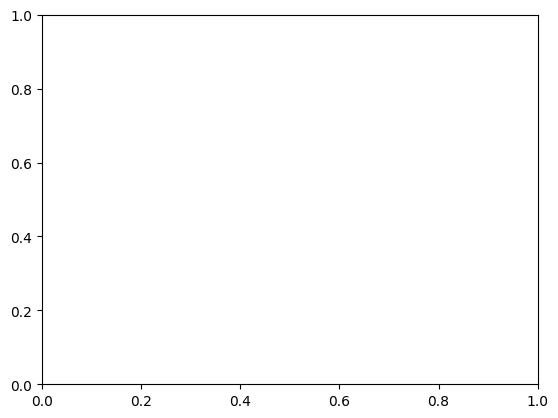

In [21]:
# mpl.use("module://matplotlib_inline.backend_inline")
plt.ioff()
fig, ax = plt.subplots()

fruits = ['apple', 'blueberry', 'cherry', 'orange']
counts = [40, 100, 30, 55]
# bar_labels = ['red', 'blue', '_red', 'orange']
# bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']
# ax.bar(fruits, counts, label=bar_labels, color=bar_colors)

# ax.set_ylabel('fruit supply')
# ax.set_title('Fruit supply by kind and color')
# ax.legend(title='Fruit color')
# ax.set_title("My Plot")
# ax.bar(0.0, 1.0)
# ax.bar(fruits, counts)

ax.set_title("")
ax.set_ylabel("")

SNP(fig, locals(), cell_lineno, provenance_is_off_by_n_lines, notebook_code_through_cell, user_names=set(re.compile(r'\b').split(cell_code)))

In [6]:
# IPython.get_ipython().kernel.shell.ast_transformers = []
# ax.bar(fruits, counts)[0]
# object_type_node(fig, mypy_result.graph)
# ls = locals()
# obj = counts
# type_graph = mypy_result.graph
# thing_type_node = type_graph[obj.__class__.__module__].tree
# name_parts =obj.__class__.__qualname__.split(".")
# last_part = name_parts[-1]
# thing_type_node.names[last_part].type
# mypy_result.graph["current_notebook"].tree.names["counts"].type
import re; x = 10; print(x)

10


In [7]:
import mypy.subtypes

counts_type = mypy_result.graph["current_notebook"].tree.names["counts"].type

arraylike_type = mypy_result.graph["matplotlib.axes"].tree.names["Axes"].node.names["bar"].node.type.arg_types[1].items[1]

counts_type

# ( mypy.subtypes.is_subtype(counts_type, counts_type)
# , mypy.subtypes.is_subtype(counts_type, arraylike_type)
# , mypy.subtypes.is_subtype(arraylike_type, counts_type)
# )


builtins.list[builtins.int]

In [16]:
# ax.containers[0].get_children()
float("inf")

inf

In [ ]:
mypy_result.graph["current_notebook"].tree.names['ax'].type.type.names
mypy_result.graph["current_notebook"].tree.names['ax'].type.type.names['xaxis'].type.type.names
mypy_result.graph["current_notebook"].tree.names['ax'].type.type.names['xaxis'].type.type.direct_base_classes()[0].names
mypy_result.graph["current_notebook"].tree.names['ax'].type.type.names['xaxis'].type.type.direct_base_classes()[0].direct_base_classes()[0].names

mypy_result.graph["current_notebook"].tree.names['fig'].type.type.names['axes'].type

In [ ]:
ax.yaxis.__class__ # matplotlib.axis.YAxis
mypy_result.graph["matplotlib.axis"].tree.names["YAxis"].node.names
mypy_result.graph["matplotlib.axis"].tree.names["YAxis"].node.direct_base_classes()[0].names["set_label_text"].type

In [ ]:
class A:
    class B:
        pass

mypy_result.graph["current_notebook"].tree.names["A"].node.names["B"].node

In [ ]:
ax.yaxis.__class__.__module__
ax.yaxis.__class__.__qualname__
ax.yaxis.__class__.__module__.split(".") + ax.yaxis.__class__.__qualname__.split(".")

In [ ]:
this_cell_code = IPython.get_ipython().history_manager.input_hist_raw[-1]

this_cell_tokens = set(re.compile(r'\b').split(this_cell_code))

stuff = locals()

for token in list(stuff):
    if token in this_cell_tokens:
        print(token, stuff[token])


In [ ]:

def object_names(locals):
    out = {}
    for name, value in [(name, value) for name, value in locals.items() if name not in trivial_names and not callable(value)]:
        key = id(value)
        out[key] = out.get(key, set()).union({name})
    return out

object_names(locals())


In [ ]:
sources, options = mypy.main.process_options([file_path])

# # options.incremental = True
# options.incremental = False
# # options.show_traceback = True
# options.preserve_asts = True
# options.strict_optional = True
# options.warn_unused_configs = True
# # options.fine_grained_incremental = True
# # options.use_fine_grained_cache = True
# options.mypy_path = ["python-type-stubs-main"]
# options.follow_imports = "silent"
# options.follow_imports_for_stubs = True
# options.export_types = True

options.incremental = True
# options.incremental = False
# options.show_traceback = True
options.preserve_asts = True
options.strict_optional = True
options.warn_unused_configs = True
options.fine_grained_incremental = True
options.use_fine_grained_cache = True
options.local_partial_types = True # https://github.com/python/mypy/issues/4492
options.mypy_path = ["python-type-stubs-main"]
options.follow_imports = "silent"
options.follow_imports_for_stubs = True
options.export_types = True

# print(options)
fscache = mypy.fscache.FileSystemCache() # IDK if this is needed
mypy_result = mypy.build.build(sources, options=options, fscache=fscache)

fine_grained_build_manager = mypy.server.update.FineGrainedBuildManager(mypy_result)

fine_grained_build_manager.update([(module_name, file_path)], [])
fine_grained_build_manager.flush_cache()
fscache.flush()


In [ ]:
{"a": "b" for k,v in [(1,2)]}

In [ ]:
[arg.initializer for arg in mypy_result.graph["matplotlib.axis"].tree.names["YAxis"].node.direct_base_classes()[0].names["set_label_text"].type.definition.arguments]

mypy_result.graph["matplotlib.axis"].tree.names["YAxis"].node.direct_base_classes()[0].names["set_label_text"].node.type.arg_kinds
mypy_result.graph["matplotlib.axis"].tree.names["YAxis"].node.direct_base_classes()[0].names["set_label_text"].type.def_extras

In [ ]:
x = object()

In [ ]:
x

In [ ]:
id(x)

In [ ]:
x = object()
y = object()
x == x

In [ ]:
def method_associations(artist):
    match artist:
        case mpl.axes.Axes() as ax:
            return [(ax.title, "set_title")]
        case mpl.axis.Axis() as axis:
            return [(axis.label, "set_label_text")]
        case _:
            return []



method_associations(ax.xaxis)